In [4]:
# 1. 把total feedback变成average feedback per submission（考虑把没有submission）给filter，老师的意思可能是要所有学生的submission数量变一样比较）
# 2. 把code length在每一个problem里面单独比较，在每个problem里分成top30%，lower 30%， 要考虑到每个problem的复杂度不同导致code length不同
# 3. 我们的motivation要为了老师或者grok academy提供帮助，eg. 帮他们判断预测一个学生需不需要重点照顾。用prediction model

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import json

In [6]:
enrolments = pd.read_json('./GrokData/enrolments.json')
enrolments

,user_id,created_at,assigned_at,slug,role,is_tutor,grade,gender,score,coursebookmark,institution_id
0,3f2464ce24df9e5e3f7df227aea411b5,2018-06-18 03:21:56,NaT,challenge-beginners-2018,STUDENT,False,7.0,F,0,True,59bc1e61f0353ee2e87647ceda3e9768
1,3a3941985aa58cd20b2ec38cddcf01e5,2018-08-28 04:15:53,2018-08-28 04:15:53,challenge-beginners-2018,PROFESSIONAL,True,NaN,None,0,False,d8ada80be429ecebca5340c31efcf718
2,d4e515deddd650591b0e9a729fcd08ac,2018-08-05 23:54:58,NaT,challenge-beginners-2018,STUDENT,False,11.0,None,190,False,e1de43293d8bb9726f00ee2f1ce8bce3
3,f3f688d53d9995b4cee250348677431b,2018-06-18 21:52:51,NaT,challenge-beginners-2018,STUDENT,False,7.0,F,0,True,c55e2534bcdae7a4bf4c64b9a7a93a25
4,8a3c2b039ebf6fde09f598b75a31d73f,2018-08-06 01:09:59,NaT,challenge-beginners-2018,STUDENT,False,7.0,M,120,False,3e8fac6ee60765f7281c161a6d185838
...,...,...,...,...,...,...,...,...,...,...,...
12893,fa97aff12eb993fa10b5761985866291,2018-08-01 05:21:05,NaT,challenge-beginners-2018,STUDENT,False,8.0,M,329,False,0e3e58b0eecac042648b7c70cb0ad11b
12894,05e2470535851b2c4df52cc9a11efe43,2018-08-21 05:28:05,NaT,challenge-beginners-2018,STUDENT,False,8.0,M,20,False,0e3e58b0eecac042648b7c70cb0ad11b
12895,39cac04c69463336d5847969b559541d,2018-08-02 00:16:38,NaT,challenge-beginners-2018,STUDENT,False,9.0,F,310,False,685bba99f4e87c979ff6e2a686a1cbc5
12896,507a64790aef22c6e62eb65c65aafe75,2018-08-01 01:18:20,NaT,challenge-beginners-2018,STUDENT,False,9.0,M,250,False,685bba99f4e87c979ff6e2a686a1cbc5


In [7]:
is_unique = not enrolments['user_id'].duplicated().any()
print(is_unique)

True


In [8]:
problems = pd.read_json('./GrokData/problems.json')
problems

,problem_id,problem_label,course_slug,coursemodule_slug,starts,ends,problem_title,slide_no,language,editor
0,18,py3-hello-world,challenge-beginners-2018,w1p1,1532901600,1534071660,"Hello, World!",5,PYTHON3,DEFAULT
1,4806,py3-breaking-news,challenge-beginners-2018,w1p1,1532901600,1534071660,Breaking News,9,PYTHON3,DEFAULT
2,4845,py3-simon-says-echo,challenge-beginners-2018,w1p1,1532901600,1534071660,Simon Says,12,PYTHON3,DEFAULT
3,4829,py3-stage-names,challenge-beginners-2018,w1p1,1532901600,1534071660,Stage Names?,16,PYTHON3,DEFAULT
4,4842,py3-dance-dance-revolution,challenge-beginners-2018,w1p1,1532901600,1534071660,Dance Dance Revolution,19,PYTHON3,DEFAULT
5,4825,py3-soup-of-the-day,challenge-beginners-2018,w1p2,1532901600,1534071660,Soup of the Day!,1,PYTHON3,DEFAULT
6,4808,py3-collecting-pikachu,challenge-beginners-2018,w1p2,1532901600,1534071660,Collecting Pikachu,7,PYTHON3,DEFAULT
7,4809,logo-cliff-climb,challenge-beginners-2018,w1p2,1532901600,1534071660,Can turtles climb?,14,LOGO,DEFAULT
8,4828,logo-mountaineer,challenge-beginners-2018,w1p2,1532901600,1534071660,Turtle Mountaineer,17,LOGO,DEFAULT
9,4846,py3-shotgun,challenge-beginners-2018,w2p1,1533506400,1534676460,Shotgun!,4,PYTHON3,DEFAULT


In [9]:
def count_submissions(dataframe):
    df_grouped = dataframe.groupby('user_id').size().reset_index(name='num_submission')
    df_grouped = df_grouped.sort_values('num_submission')
    return df_grouped

submission_path = './FirstTwoWeeks/submissions/'
submissions_dict = {}

i = 0
for filename in os.listdir(submission_path):
    name = 'probelm {}'.format(i)
    file_path = os.path.join(submission_path, filename)
    df = pd.read_json(file_path)
    grouped_df = count_submissions(df)
    submissions_dict[name] = grouped_df
    i += 1


In [10]:
submissions_dict

{'probelm 0':                                user_id  num_submission
 0     0008c93cbc047666cab8ec9b06e7fb43               1
 3195  9c0235d8804b0030f63aa47581a57a02               1
 3196  9c086cf67e0dd3037b7eeffd4dff46de               1
 3197  9c2b0cfcb6dd07176892111a289220c9               1
 3199  9c4170024ad702bc51a84da732cb3c63               1
 ...                                ...             ...
 3693  b58255948a034c3642405edc2847e564              16
 4580  df7aa2dc0525d507cdcb8bba3bb023e1              16
 3023  925361c839e73d16615c231a63b6a36c              16
 192   0a0bfd1869e9f831961283ac0db3b5a2              21
 999   2fa22be5a669264e777d7b0cc2335969              32
 
 [5247 rows x 2 columns],
 'probelm 1':                                user_id  num_submission
 0     0008c93cbc047666cab8ec9b06e7fb43               1
 3902  9d75c6c2cdccaeab8bf9d75bfac6f9fb               1
 3901  9d5b9286f0fe2816d18a72e0c9e46b76               1
 3899  9d53bb8ee540c21052cc2ea6a2a146dd           

In [11]:
def combine_json_files(folder_path):
    all_data = []  # List to store data from all JSON files

    # Iterate over files in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        with open(file_path, 'r') as json_file:
            data = json.load(json_file)

        all_data.extend(data)

    df = pd.DataFrame(all_data)
    return df

# Combine submission files
submission_path = './FirstTwoWeeks/submissions/'
submissions = combine_json_files(submission_path)
submissions


,user_id,id,created_at,status,files,results,failed_label,already_passed
0,688eb80cfdb8b6aa7a3b678e53067e72,10127948,1533699734,PASSED,[{'content': 'from turtle import * way = input...,None,None,False
1,2062193ceebc168a3a27864e2071ba6a,10000496,1533522625,PASSED,[{'content': 'from turtle import * d=input('Wh...,None,None,False
2,2062193ceebc168a3a27864e2071ba6a,9999913,1533522412,FAILED,[{'content': 'from turtle import * d=input('Wh...,"[{'status': 0, 'msg': 'Testing the prompt.', '...",right-second-line,False
3,2062193ceebc168a3a27864e2071ba6a,9999652,1533522307,FAILED,[{'content': 'from turtle import * d=input('Wh...,"[{'status': 0, 'msg': 'Testing the prompt.', '...",right-first-line,False
4,e8679b3a9af51fc4f8c81d21c3fd3a35,9978694,1533512036,PASSED,[{'content': 'from turtle import * direction= ...,None,None,False
...,...,...,...,...,...,...,...,...
186962,0e12032a07460df91450c7ae18fddfd7,17113939,1564293419,PASSED,[{'content': 'yips = int(input('How many yips?...,None,None,False
186963,0e12032a07460df91450c7ae18fddfd7,17113936,1564293392,FAILED,[{'content': 'yips = int(input('How many yips?...,"[{'status': 1, 'type': 0, 'label': 'eg1', 'dat...",eg1,False
186964,ed15665a8ee504d4ef87b1b64a2f821d,10254206,1533964544,PASSED,[{'content': 'yips = int(input('How many yips?...,None,None,False
186965,4244949b239a0e4562201e805b2cd7b5,10253705,1533963466,PASSED,"[{'content': 'yip = int(input(""How many yips? ...",None,None,False


In [12]:
grouped_submissions = count_submissions(submissions)
grouped_submissions

,user_id,num_submission
4923,9fa148dc1be5e489caddf2c7b9be12a3,1
6310,cd0c44310915eac04832eadcdf37c342,1
1574,33c4f9cd438ffd4a39cc866ca2a9f91b,1
4485,907e7c7c909ca4e3fc42e7c51b2f3a86,1
322,0b54e4d144c860daed14bfac5a29b463,1
...,...,...
1075,240c2238ec111aac7c14dbb7e634fb82,119
5071,a4586254edf6b3068a8f0560d1934071,121
4669,96d1a28fc39d8102b39e61b03b179e37,125
5237,aaadc51da693ef21de963c890928b244,133


In [13]:
result = pd.merge(enrolments, grouped_submissions, on='user_id', how='left')[['user_id', 'score', 'num_submission']].sort_values('user_id')
result['num_submission'] = result['num_submission'].fillna(0)
result

,user_id,score,num_submission
7383,0008c93cbc047666cab8ec9b06e7fb43,399,20.0
12752,00093daf36073e2aeb7b2723135c21d1,339,26.0
1840,000b51052a5e303dcefc14e077044865,200,18.0
2865,000c11bdc5aa25d11cb9d5c7b268b13b,0,0.0
213,0017e1dfb8022a9cc4376edf1a72249d,0,4.0
...,...,...,...
10633,ffe7b69c70d4435b15b442760ec1e7cf,320,26.0
2205,ffeb3e0e0a721e8bc574d0c292d4b772,0,0.0
4529,fff3d648f1878a34a52634d07d3c2694,60,28.0
5747,fff717aeb51d6b58be1e7168eecbb7f0,410,23.0


In [14]:
def num_feedback(dataframe):
    filtered_df = dataframe[dataframe['was_student'] == False]
    df_grouped = filtered_df.groupby('user_id').size().reset_index(name='num_feedback')
    df_grouped = df_grouped.sort_values('num_feedback')
    
    return df_grouped

feedback_path = './FirstTwoWeeks/feedbacks/'
feedbacks_dict = {}

i = 0
for filename in os.listdir(feedback_path):
    name = 'probelm {}'.format(i)
    file_path = os.path.join(feedback_path, filename)
    df = pd.read_json(file_path)
    grouped_df = num_feedback(df)
    feedbacks_dict[name] = grouped_df
    i += 1
feedbacks_dict

{'probelm 0':                              user_id  num_feedback
 40  6ad0adc2cfc9d88037c4b872ce1f30e6             1
 29  52acdf5317ebc60af74d7971632f1bfd             1
 32  6009e1cbe7b88e203d1240d1cae91f6a             1
 33  61998b920641c07c77af3d0cce9cb7c7             1
 37  6654717803ded3348e7ca1398c171e7e             1
 ..                               ...           ...
 39  694c54569ef15d46e06c580e3bb4ef38            10
 51  9f2b4cb3f094814d092c492c54c68c7d            12
 41  6b48878bbaca201789c5b8578bd18711            13
 53  a0cb0b2e2e0087d31e53d7ff0e07a1b0            21
 31  5fda6a83a24729290435b3081bb2681a            23
 
 [81 rows x 2 columns],
 'probelm 1':                              user_id  num_feedback
 0   000b51052a5e303dcefc14e077044865             1
 37  6672c2727d61090056eb3fc32bbd9944             1
 41  6b7f11bcf83656b887841b67c7dc7009             1
 43  6c69f9fe90a062d7f9adbafc27975864             1
 44  6d9987949d6fa28802e983fdd4ad06b7             1
 ..         

In [15]:
all_feedbacks = pd.concat(feedbacks_dict.values(), ignore_index=True).sort_values('user_id')
print(all_feedbacks)


                               user_id  num_feedback
81    000b51052a5e303dcefc14e077044865             1
390   000b51052a5e303dcefc14e077044865             1
861   000b51052a5e303dcefc14e077044865             5
732   000b51052a5e303dcefc14e077044865             1
596   0021f5a039370431c495ecbf719ac6ca             1
...                                ...           ...
1031  ff45e334ff488ebd4b5a17504140eaec             1
323   ff479ac2f8d184d43122a22a88305ae7             1
245   ff479ac2f8d184d43122a22a88305ae7             1
780   ffbd9fd85b4c243067a0846f544c425b             1
282   ffe7b69c70d4435b15b442760ec1e7cf             3

[1086 rows x 2 columns]


In [16]:

# Group by user_id and calculate the average num_feedback
grouped_feedbacks = all_feedbacks.groupby('user_id').agg(avg_feedback=('num_feedback', 'mean')).reset_index().sort_values('user_id')
print(grouped_feedbacks)


                              user_id  avg_feedback
0    000b51052a5e303dcefc14e077044865           2.0
1    0021f5a039370431c495ecbf719ac6ca           1.0
2    003c4047ee396a6cfa83dc98b8351125           1.0
3    01150d38ae269710dbd4fa968e0129d4           4.0
4    02a791dd03efb2706f057d8f81b12b41           2.0
..                                ...           ...
613  fef5c23b029e066da7c9974b7a23ce78           3.0
614  ff45e334ff488ebd4b5a17504140eaec           1.0
615  ff479ac2f8d184d43122a22a88305ae7           1.0
616  ffbd9fd85b4c243067a0846f544c425b           1.0
617  ffe7b69c70d4435b15b442760ec1e7cf           3.0

[618 rows x 2 columns]


In [17]:
final_result = pd.merge(result, grouped_feedbacks, on='user_id', how='left')[['user_id', 'score', 'num_submission', 'avg_feedback']].sort_values('user_id')
final_result['avg_feedback'] = final_result['avg_feedback'].fillna(0)
final_result

,user_id,score,num_submission,avg_feedback
0,0008c93cbc047666cab8ec9b06e7fb43,399,20.0,0.0
1,00093daf36073e2aeb7b2723135c21d1,339,26.0,0.0
2,000b51052a5e303dcefc14e077044865,200,18.0,2.0
3,000c11bdc5aa25d11cb9d5c7b268b13b,0,0.0,0.0
4,0017e1dfb8022a9cc4376edf1a72249d,0,4.0,0.0
...,...,...,...,...
12893,ffe7b69c70d4435b15b442760ec1e7cf,320,26.0,3.0
12894,ffeb3e0e0a721e8bc574d0c292d4b772,0,0.0,0.0
12895,fff3d648f1878a34a52634d07d3c2694,60,28.0,0.0
12896,fff717aeb51d6b58be1e7168eecbb7f0,410,23.0,0.0


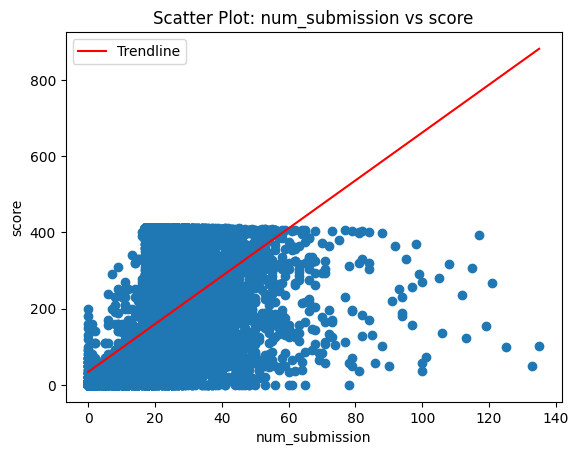

In [18]:
x_name = 'num_submission'
y_name = 'score'

x = final_result[x_name]
y = final_result[y_name]

# Scatter plot
plt.scatter(x, y)
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title('Scatter Plot: {} vs {}'.format(x_name, y_name))

# Add trendline
coefficients = np.polyfit(x, y, 1)  # Fit a 1st-degree polynomial (line) to the data
polynomial = np.poly1d(coefficients)  # Create a polynomial function
x_values = np.linspace(min(x), max(x), 100)  # Generate x values for the trendline
y_values = polynomial(x_values)  # Calculate y values using the polynomial function
plt.plot(x_values, y_values, color='red', label='Trendline')

plt.legend()  # Display the legend
plt.show()


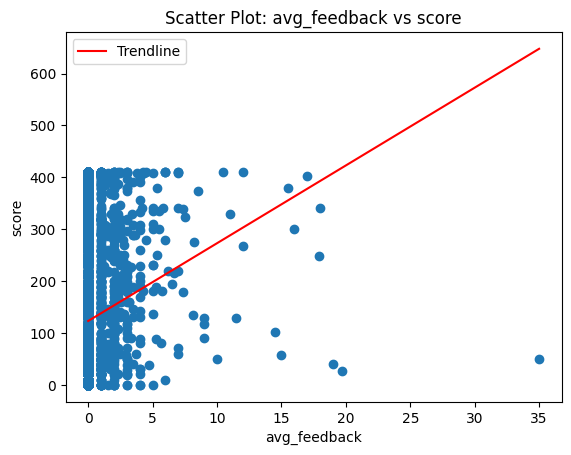

In [19]:
x_name = 'avg_feedback'
y_name = 'score'

x = final_result[x_name]
y = final_result[y_name]

# Scatter plot
plt.scatter(x, y)
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title('Scatter Plot: {} vs {}'.format(x_name, y_name))

# Add trendline
coefficients = np.polyfit(x, y, 1)  # Fit a 1st-degree polynomial (line) to the data
polynomial = np.poly1d(coefficients)  # Create a polynomial function
x_values = np.linspace(min(x), max(x), 100)  # Generate x values for the trendline
y_values = polynomial(x_values)  # Calculate y values using the polynomial function
plt.plot(x_values, y_values, color='red', label='Trendline')

plt.legend()  # Display the legend
plt.show()


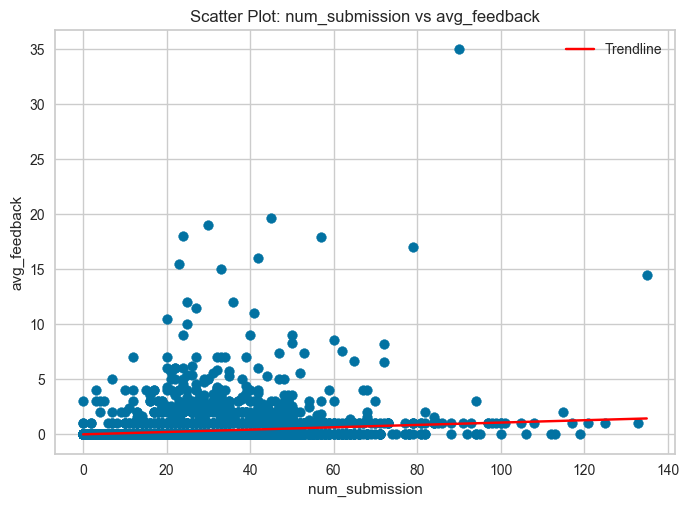

In [51]:
x_name = 'num_submission'
y_name = 'avg_feedback'

x = final_result[x_name]
y = final_result[y_name]

# Scatter plot
plt.scatter(x, y)
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title('Scatter Plot: {} vs {}'.format(x_name, y_name))

# Add trendline
coefficients = np.polyfit(x, y, 1)  # Fit a 1st-degree polynomial (line) to the data
polynomial = np.poly1d(coefficients)  # Create a polynomial function
x_values = np.linspace(min(x), max(x), 100)  # Generate x values for the trendline
y_values = polynomial(x_values)  # Calculate y values using the polynomial function
plt.plot(x_values, y_values, color='red', label='Trendline')

plt.legend()  # Display the legend
plt.show()


In [20]:
from scipy.stats import spearmanr

features_corr, p_values = spearmanr(final_result[['score', 'num_submission', 'avg_feedback']])

print("Spearman correlation coefficients:")
print(features_corr)

print("P-values:")
print(p_values)

Spearman correlation coefficients:
[[1.         0.82841752 0.14891057]
 [0.82841752 1.         0.26544621]
 [0.14891057 0.26544621 1.        ]]
P-values:
[[0.00000000e+000 0.00000000e+000 7.55014490e-065]
 [0.00000000e+000 0.00000000e+000 6.45336505e-207]
 [7.55014490e-065 6.45336505e-207 0.00000000e+000]]


In [21]:
correlation = final_result[['score', 'num_submission', 'avg_feedback']].corr(method='spearman')

# Print the correlation matrix with p-values
print("Correlation: ")
print(correlation)

Correlation: 
                   score  num_submission  avg_feedback
score           1.000000        0.828418      0.148911
num_submission  0.828418        1.000000      0.265446
avg_feedback    0.148911        0.265446      1.000000


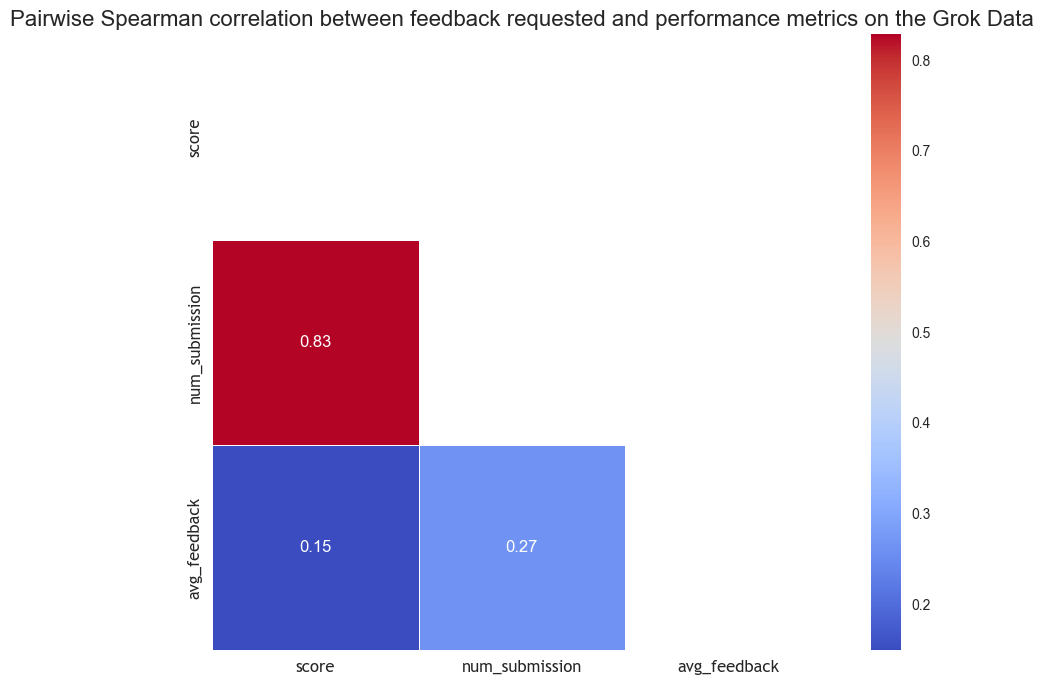

In [52]:
# Create a mask for upper triangular portion
mask = np.triu(np.ones_like(correlation, dtype=bool))

# Set the figure size
plt.figure(figsize=(10, 8))

# Create a correlation heatmap with improved theme
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask=mask)

# Set the title of the plot
plt.title('Pairwise Spearman correlation between feedback requested and performance metrics on the Grok Data', fontsize=16)

# # Customize the colorbar
# cbar = plt.colorbar()
# cbar.ax.tick_params(labelsize=12)

# Set the font size of the annotations
plt.xticks(fontsize=12, fontfamily="Trebuchet MS")
plt.yticks(fontsize=12, fontfamily="Trebuchet MS")

# Display the plot
plt.show()

In [22]:
# RQ3 starts here
final_result['score'].mean()

124.68475732671732

In [23]:
final_result['failure_risk'] = np.nan
final_result.loc[final_result['score'] < 125, 'failure_risk'] = 'high' 
final_result.loc[final_result['score'] > 200, 'failure_risk'] = 'low' 
final_result.loc[(final_result['score'] >= 125) & (final_result['score'] <= 200), 'failure_risk'] = 'medium' 
final_result

,user_id,score,num_submission,avg_feedback,failure_risk
0,0008c93cbc047666cab8ec9b06e7fb43,399,20.0,0.0,low
1,00093daf36073e2aeb7b2723135c21d1,339,26.0,0.0,low
2,000b51052a5e303dcefc14e077044865,200,18.0,2.0,medium
3,000c11bdc5aa25d11cb9d5c7b268b13b,0,0.0,0.0,high
4,0017e1dfb8022a9cc4376edf1a72249d,0,4.0,0.0,high
...,...,...,...,...,...
12893,ffe7b69c70d4435b15b442760ec1e7cf,320,26.0,3.0,low
12894,ffeb3e0e0a721e8bc574d0c292d4b772,0,0.0,0.0,high
12895,fff3d648f1878a34a52634d07d3c2694,60,28.0,0.0,high
12896,fff717aeb51d6b58be1e7168eecbb7f0,410,23.0,0.0,low


In [24]:
final_data = final_result.drop(columns=['user_id', 'score'])
final_data

,num_submission,avg_feedback,failure_risk
0,20.0,0.0,low
1,26.0,0.0,low
2,18.0,2.0,medium
3,0.0,0.0,high
4,4.0,0.0,high
...,...,...,...
12893,26.0,3.0,low
12894,0.0,0.0,high
12895,28.0,0.0,high
12896,23.0,0.0,low


In [25]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12898 entries, 0 to 12897
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   num_submission  12898 non-null  float64
 1   avg_feedback    12898 non-null  float64
 2   failure_risk    12898 non-null  object 
dtypes: float64(2), object(1)
memory usage: 403.1+ KB


In [26]:
# Split the dataset
#import the necessary module
from sklearn.model_selection import train_test_split
# Generate the trainning set and testing set
data_feature = final_data.loc[:, final_data.columns!="failure_risk"]
target = final_data.loc[:, "failure_risk"]
data_train, data_test, target_train, target_test  = train_test_split(data_feature,target, test_size = 0.30, random_state = 10)

In [27]:
# LinearSVC Method 
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
#create an object of type LinearSVC
svc_model = LinearSVC(random_state=0)
#train the algorithm on training data and predict using the testing data
pred = svc_model.fit(data_train, target_train).predict(data_test)
#print the accuracy score of the model
print("LinearSVC accuracy : ",accuracy_score(target_test, pred))

LinearSVC accuracy :  0.7320413436692507


C:\Users\samch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [28]:
# Decision tree Method - entropy
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot
from sklearn.metrics import accuracy_score
# define the model
dtc_model = DecisionTreeClassifier(criterion="entropy", max_depth=20, random_state=3)
# fit the model
dtc_model.fit(data_train, target_train)
dtc_pred = dtc_model.predict(data_test)
#print the accuracy score of the model
print("DecisionTreeClassifier accuracy : ", accuracy_score(target_test, dtc_pred))

DecisionTreeClassifier accuracy :  0.8219638242894057


In [44]:
# Decision tree Method - gini
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot
from sklearn.metrics import accuracy_score
# define the model
dtc_model = DecisionTreeClassifier(criterion="gini", max_depth=20, random_state=3)
# fit the model
dtc_model.fit(data_train, target_train)
dtc_pred = dtc_model.predict(data_test)
#print the accuracy score of the model
print("DecisionTreeClassifier accuracy : ", accuracy_score(target_test, dtc_pred))

DecisionTreeClassifier accuracy :  0.8224806201550388


In [37]:
# Random Forrest Method

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# define the model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# fit the model
rf_classifier.fit(data_train, target_train)
predicted_probas = rf_classifier.predict_proba(data_test)
rf_pred = rf_classifier.predict(data_test)
#print the accuracy score of the model
print("DecisionTreeClassifier accuracy : ", accuracy_score(target_test, rf_pred))

DecisionTreeClassifier accuracy :  0.8240310077519379


In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Define the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf_classifier, data_feature, target, cv=5)

# Print the accuracy scores for each fold
print("Accuracy scores for each fold:", cv_scores)

# Print the mean accuracy score and standard deviation
print("Mean accuracy score:", cv_scores.mean())
print("Standard deviation:", cv_scores.std())


Accuracy scores for each fold: [0.81976744 0.82054264 0.81395349 0.82124855 0.81737107]
Mean accuracy score: 0.8185766371798454
Standard deviation: 0.002655151581657786


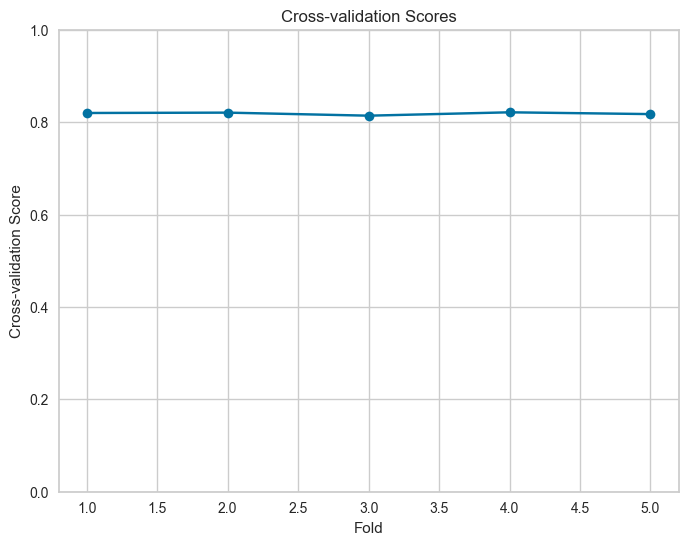

In [50]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o')
plt.xlabel('Fold')
plt.ylabel('Cross-validation Score')
plt.title('Cross-validation Scores')
plt.ylim(0, 1)  # Set y-axis limits to better visualize the scores
plt.show()

In [39]:
import sys
!{sys.executable} -m pip install scikit-plot
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(target_test, predicted_probas)


  Using cached scikit_plot-0.3.7-py3-none-any.whl (33 kB)


You should consider upgrading via the 'C:\Users\samch\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


ValueError: Cannot calculate Cumulative Gains for data with 3 category/ies

You should consider upgrading via the 'C:\Users\samch\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.
C:\Users\samch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\samch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\numpy\lib\arraysetops.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
C:\Users\samch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision an

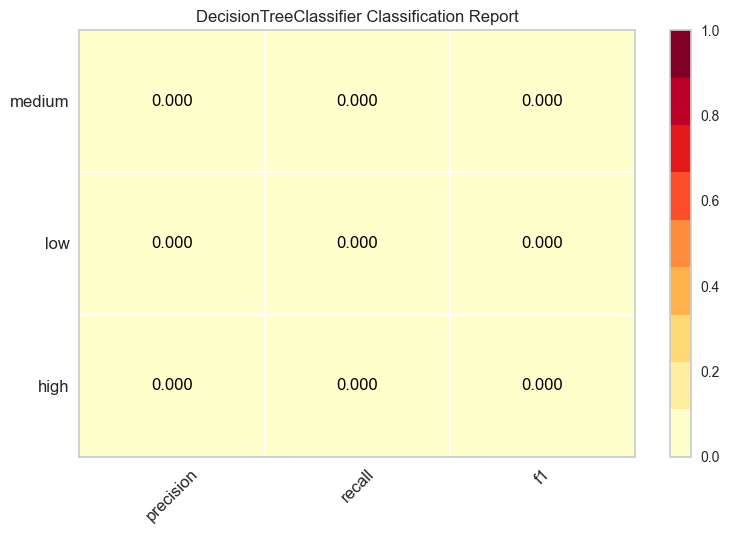

In [45]:
!{sys.executable} -m pip install yellowbrick
# Evaluation of our model
from yellowbrick.classifier import ClassificationReport
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(dtc_model, classes=['high','low', 'medium'])
visualizer.fit(data_train, target_train) # Fit the training data to the visualizer
visualizer.score(data_test, target_test) # Evaluate the model on the test data
g = visualizer.poof()